### More Testing on Multiple Linear Regression Models

Import modules

In [144]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LassoCV, MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

Load in games data and transform to create efensive yards allowed data 

In [2]:
pd.set_option('display.max_columns', 500)

In [103]:
all_games_df = pd.DataFrame(data = pd.read_csv('all_games_data.csv', index_col=0))
field_pos_df = pd.DataFrame(data = pd.read_csv('all_games_field_pos_data.csv', index_col=0))
recruit_df = pd.DataFrame(data = pd.read_csv('all_teams_recruit_data.csv', index_col=0))
clean_games_df = pd.DataFrame(data = pd.read_csv('clean_games_with_opp.csv', index_col=0))

If I ever am able to get all the field position stuff then it can go here

In [4]:
# final_df = pd.merge(clean_games_df, field_pos_df,  how='left', left_on= ['id','school'], right_on = ['game_id','team'])
# final_df = final_df.drop(columns=['game_id','team'])
# final_df.head()

In [104]:
clean_games_df.reset_index(drop=True, inplace=True)
clean_games_df.head()

,school,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,interceptionYards,interceptionTDs,passesIntercepted,firstDowns,thirdDownEff,fourthDownEff,totalYards,netPassingYards,completionAttempts,yardsPerPass,rushingYards,rushingAttempts,yardsPerRushAttempt,totalPenaltiesYards,turnovers,fumblesLost,interceptions,possessionTime,puntReturnYards,puntReturnTDs,puntReturns,totalFumbles,tacklesForLoss,defensiveTDs,tackles,sacks,qbHurries,passesDeflected,possession_minutes,possession_seconds,poss_total_sec,id,year,week,opposing_netPassingYards,opposing_yardsPerPass,opposing_rushingYards,opposing_yardsPerRushAttempt,opposing_passingTDs,opposing_rushingTDs,opposing_points,side,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage
0,Navy,2426,17,0.0,2.0,0.0,64.0,0.0,4.0,5.0,0.0,0.0,1.0,22.0,0.333333,1.0,390.0,20.0,2-4,5.0,370.0,63.0,5.9,3-20,1.0,1.0,0.0,32:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,26.0,1946.0,400547982,2014,1,226.0,15.1,194.0,4.8,2.0,1.0,34,A,4.0,12.0,1.0,1.0,2.0,4.0,0.500000
1,UAB,5,48,1.0,4.0,2.0,64.0,0.0,2.0,12.0,NaN,NaN,NaN,25.0,0.642857,NaN,490.0,152.0,13-20,7.6,338.0,55.0,6.1,3-35,2.0,1.0,1.0,30:17,14.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,17.0,1817.0,400548010,2014,1,201.0,6.5,71.0,2.0,0.0,1.0,10,A,9.0,14.0,0.0,0.0,13.0,20.0,0.650000
2,UMass,113,7,0.0,0.0,1.0,95.0,0.0,4.0,1.0,20.0,0.0,1.0,9.0,0.272727,0.0,202.0,147.0,9-22,6.7,55.0,22.0,2.5,4-23,1.0,0.0,1.0,17:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,49.0,1069.0,400547728,2014,1,173.0,6.9,338.0,5.5,1.0,2.0,30,A,3.0,11.0,1.0,1.0,9.0,22.0,0.409091
3,UCF,2116,24,1.0,2.0,1.0,142.0,0.0,5.0,6.0,0.0,0.0,2.0,11.0,0.384615,0.5,246.0,222.0,12-22,10.1,24.0,29.0,0.8,8-47,1.0,1.0,0.0,25:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,27.0,1527.0,400547642,2014,1,454.0,9.7,57.0,2.0,1.0,1.0,26,A,5.0,13.0,2.0,2.0,12.0,22.0,0.545455
4,Houston,248,7,1.0,1.0,0.0,89.0,0.0,6.0,1.0,NaN,NaN,NaN,18.0,0.250000,0.5,208.0,234.0,25-50,4.7,-26.0,23.0,-1.1,9-47,6.0,2.0,4.0,22:14,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,14.0,1334.0,400547644,2014,1,121.0,5.0,142.0,2.8,0.0,3.0,27,A,4.0,16.0,4.0,4.0,25.0,50.0,0.500000


In [ ]:
# Used this to see how any columns had nulls and how many nulls
# clean_games_df.isna().sum() 

In [105]:
# Dropping all columns with more than 25 nulls, then dropping the individual rows that have nulls
x = clean_games_df.isna().sum().to_dict()
column_drop = []

for k, v in x.items():
    if v > 25 :
        column_drop.append(k)

# Additionally, these columns are weird formats or already covered by other variables (ie the possession stuff)
extend_list = ('completionAttempts','totalPenaltiesYards','possessionTime','possession_minutes','possession_seconds','year','week','school','school_id')

column_drop.extend(extend_list)

clean_games_df.drop(columns=column_drop, inplace = True)
clean_games_df.dropna(axis = 0, inplace = True)

In [106]:
train_density = 0.8
games_ids = set(clean_games_df["id"])
train_ids = random.sample(list(games_ids), int(train_density*len(games_ids)))
test_ids = list(games_ids - set(train_ids))

Extracting Test and Train Games

In [107]:
test_games_df = clean_games_df[clean_games_df["id"].isin(test_ids)]
train_games_df = clean_games_df[clean_games_df["id"].isin(train_ids)]
train_games_df.head()

,points,fumblesRecovered,rushingTDs,passingTDs,firstDowns,thirdDownEff,totalYards,netPassingYards,yardsPerPass,rushingYards,rushingAttempts,yardsPerRushAttempt,turnovers,fumblesLost,interceptions,poss_total_sec,id,opposing_netPassingYards,opposing_yardsPerPass,opposing_rushingYards,opposing_yardsPerRushAttempt,opposing_passingTDs,opposing_rushingTDs,opposing_points,side,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage
0,17,0.0,2.0,0.0,22.0,0.333333,390.0,20.0,5.0,370.0,63.0,5.9,1.0,1.0,0.0,1946.0,400547982,226.0,15.1,194.0,4.8,2.0,1.0,34,A,4.0,12.0,1.0,1.0,2.0,4.0,0.500000
1,48,1.0,4.0,2.0,25.0,0.642857,490.0,152.0,7.6,338.0,55.0,6.1,2.0,1.0,1.0,1817.0,400548010,201.0,6.5,71.0,2.0,0.0,1.0,10,A,9.0,14.0,0.0,0.0,13.0,20.0,0.650000
2,7,0.0,0.0,1.0,9.0,0.272727,202.0,147.0,6.7,55.0,22.0,2.5,1.0,0.0,1.0,1069.0,400547728,173.0,6.9,338.0,5.5,1.0,2.0,30,A,3.0,11.0,1.0,1.0,9.0,22.0,0.409091
4,7,1.0,1.0,0.0,18.0,0.250000,208.0,234.0,4.7,-26.0,23.0,-1.1,6.0,2.0,4.0,1334.0,400547644,121.0,5.0,142.0,2.8,0.0,3.0,27,A,4.0,16.0,4.0,4.0,25.0,50.0,0.500000
5,45,2.0,3.0,3.0,31.0,0.500000,574.0,313.0,6.7,261.0,50.0,5.2,2.0,1.0,1.0,1806.0,400547648,91.0,2.3,-24.0,-1.0,0.0,0.0,0,A,10.0,20.0,2.0,2.0,27.0,47.0,0.574468


In [126]:
test_games_df.keys()

Index(['points', 'fumblesRecovered', 'rushingTDs', 'passingTDs', 'firstDowns',
       'thirdDownEff', 'totalYards', 'netPassingYards', 'yardsPerPass',
       'rushingYards', 'rushingAttempts', 'yardsPerRushAttempt', 'turnovers',
       'fumblesLost', 'interceptions', 'poss_total_sec', 'id',
       'opposing_netPassingYards', 'opposing_yardsPerPass',
       'opposing_rushingYards', 'opposing_yardsPerRushAttempt',
       'opposing_passingTDs', 'opposing_rushingTDs', 'opposing_points', 'side',
       'thirdDownConverts', 'thirdDownAttempts', 'fourthDownConverts',
       'fourthDownAttempts', 'completions', 'passAttempts',
       'passCompletionPercentage'],
      dtype='object')

Test and Train data

In [128]:
train_games_df.side.value_counts()['H']
# 6476
train_games_df.side.value_counts()['A']
# 6478

test_games_df.side.value_counts()['H']
test_games_df.side.value_counts()['A']
# Both 1620

# Two games do not have a home side and an away side, which was messing with the X_train y_train assignment
# Fixing that here by dropping those games

# All the home IDs
home_ids = train_games_df.loc[train_games_df.side == 'H'].id.values
# All the away IDs
away_ids = train_games_df.loc[train_games_df.side == 'A'].id.values

# IDs missing home values
missing_home = set(away_ids) - set(home_ids)

for id in missing_home:
    train_games_df.drop(train_games_df.loc[train_games_df['id'] == id].index, inplace=True)
    train_ids.remove(id)

In [129]:
# Did it work?
print(train_games_df.side.value_counts()['A']
,train_games_df.side.value_counts()['H'], len(train_ids))

6476 6476 6476


In [130]:
pd.options.mode.chained_assignment = None  # default='warn'

X_train = []
y_train = []

for id in train_ids:
    temp = train_games_df.loc[train_games_df["id"] == id]
    temp_home = temp.loc[temp["side"] == 'H']
    temp_away = temp.loc[temp["side"] == 'A']

    y_train.append(np.array([temp_home["points"], temp_away["points"]]))
    temp_home.drop(["side", "points", "id"], axis=1, inplace=True)
    temp_away.drop(["side", "points", "id"], axis=1, inplace=True)

    temp_home = temp_home.to_numpy()
    temp_away = temp_away.to_numpy()

    X_train.append(np.concatenate([temp_home, temp_away], axis=1)[0])

X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 2)

In [131]:
X_test = []
y_test = []
for id in test_ids:
    temp = test_games_df.loc[test_games_df["id"] == id]
    temp_home = temp.loc[temp["side"] == 'H']
    temp_away = temp.loc[temp["side"] == 'A']
    y_test.append(np.array([temp_home["points"], temp_away["points"]]))
    temp_home.drop(["side", "points", "id"], axis=1, inplace=True)
    temp_away.drop(["side", "points", "id"], axis=1, inplace=True)

    temp_home = temp_home.to_numpy()
    temp_away = temp_away.to_numpy()
    X_test.append(np.concatenate([temp_home, temp_away], axis=1)[0])

X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1, 2)

Scaling the Model

In [132]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [170]:
pca = PCA()
pca.fit(X_train_scaled)
pca_data = pca.transform(X_train_scaled)

In [171]:
pca_data.shape
per_var = np.round(pca.explained_variance_ratio_* 100,decimals=1)

print(len(per_var))

58


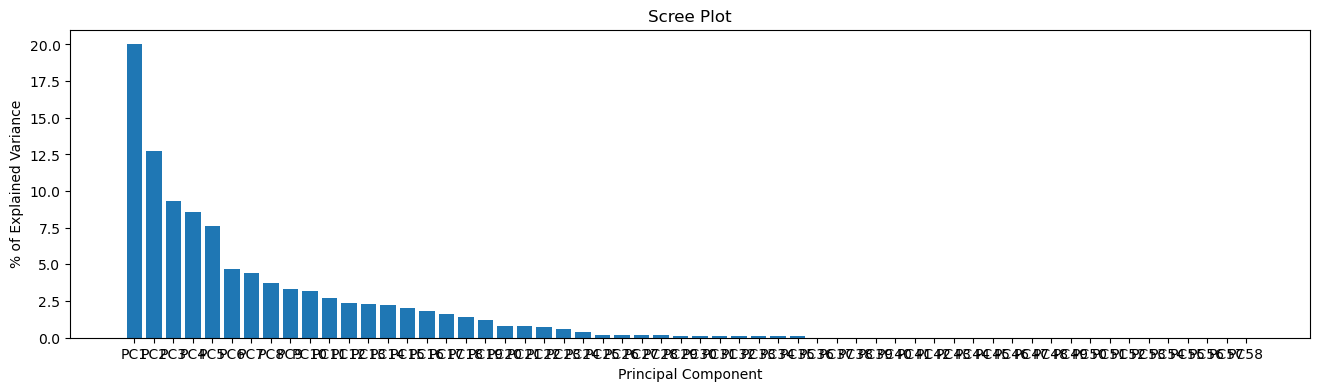

In [185]:

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' +str(x) for x in range (1,len(per_var) + 1)]


plt.figure(figsize=(16,4))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label = labels)
plt.ylabel('% of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

Simple Linear Regression MAE
Doesn't work at all - clearly some variables that are not impactful / driving the bus too much

In [114]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

print(f"MAE with linear regression:{mean_absolute_error(linreg.predict(X_test_scaled), y_test)}")
# OK so that doesn't work.... Must be some variables here that have no impact or even a negative influence on our outcomes.

MAE with linear regression:1.2402567101749482e-06


Lasso and Elastic Net MAE

Lasso seems to perform the best, indicating some features that should be removed from the dataset

Another thought here is that the standard scaler may not work for all features we are inputting

In [195]:
lasso = Lasso(alpha=1)
lasso.fit(X_train_scaled, y_train)

ela_net = ElasticNet(alpha=1)
ela_net.fit(X_train_scaled, y_train)

lasso_cv = MultiTaskLassoCV(cv=10, random_state=752)
lasso_cv.fit(X_train_scaled, y_train)

ela_net_cv = MultiTaskElasticNetCV(cv=10,random_state=752)
ela_net_cv.fit(X_train_scaled, y_train)

print(f"MAE are Lasso:{mean_absolute_error(lasso.predict(X_test_scaled), y_test)},\
       ElasticNet:{mean_absolute_error(ela_net.predict(X_test_scaled), y_test)},\
        LassoCV:{mean_absolute_error(lasso_cv.predict(X_test_scaled), y_test)}, \
        ElasticNetCV:{mean_absolute_error(ela_net_cv.predict(X_test_scaled), y_test)} ")


MAE are Lasso:0.8180543500941445,       ElasticNet:2.911971383818388,        LassoCV:0.013040024427970061,         ElasticNetCV:0.4782769732668568 


In [235]:
lasso_cv_residuals = y_test - lasso_cv.predict(X_test_scaled)
lasso_residuals = y_test - lasso.predict(X_test_scaled)
ela_net_cv_residuals = y_test - ela_net_cv.predict(X_test_scaled)
ela_net_residuals = y_test - ela_net.predict(X_test_scaled)

In [231]:
ela_net_cv_residuals

array([[ 0.00732679, -0.52245319],
       [-0.4025164 , -0.54271213],
       [ 0.19187062, -0.88592978],
       ...,
       [-0.57250505, -0.50577484],
       [ 0.65974739,  0.32965974],
       [-0.3673381 ,  0.8290971 ]])

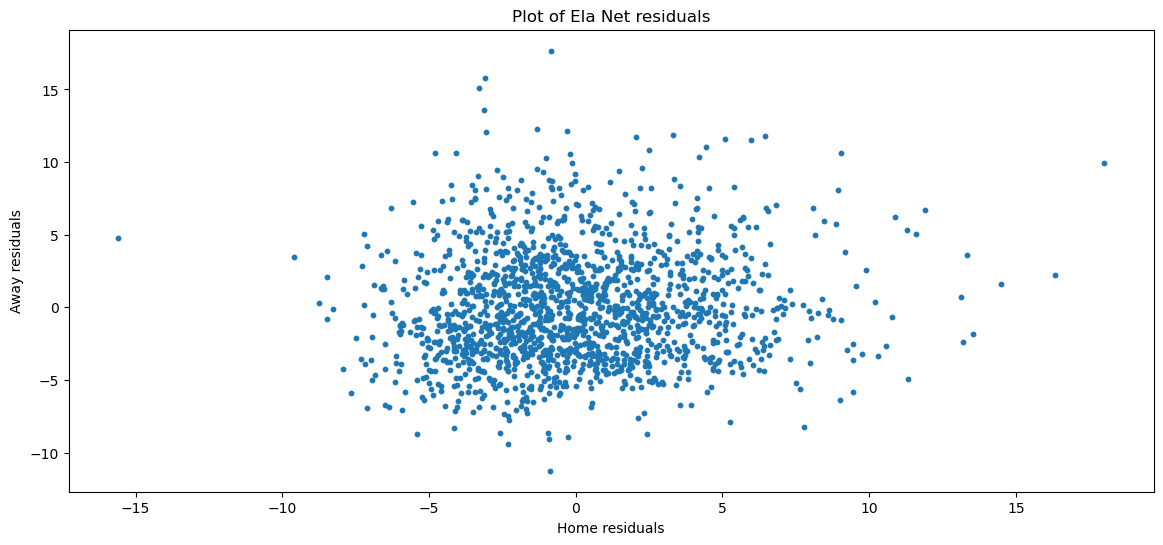

In [239]:
plt.figure(figsize=(14,6))

plt.scatter(x = ela_net_residuals[:,0], y = ela_net_residuals[:,1], s=10)
plt.title('Plot of Ela Net residuals')
plt.xlabel('Home residuals')
plt.ylabel('Away residuals')
plt.show()

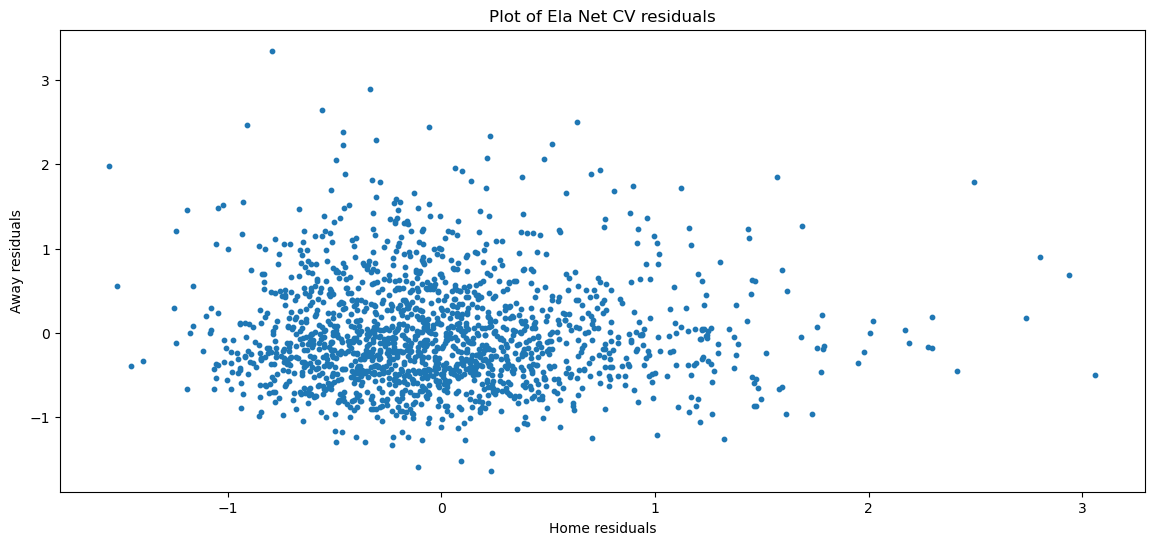

In [241]:
plt.figure(figsize=(14,6))

plt.scatter(x = ela_net_cv_residuals[:,0], y = ela_net_cv_residuals[:,1], s=10)
plt.title('Plot of Ela Net CV residuals')
plt.xlabel('Home residuals')
plt.ylabel('Away residuals')
plt.show()

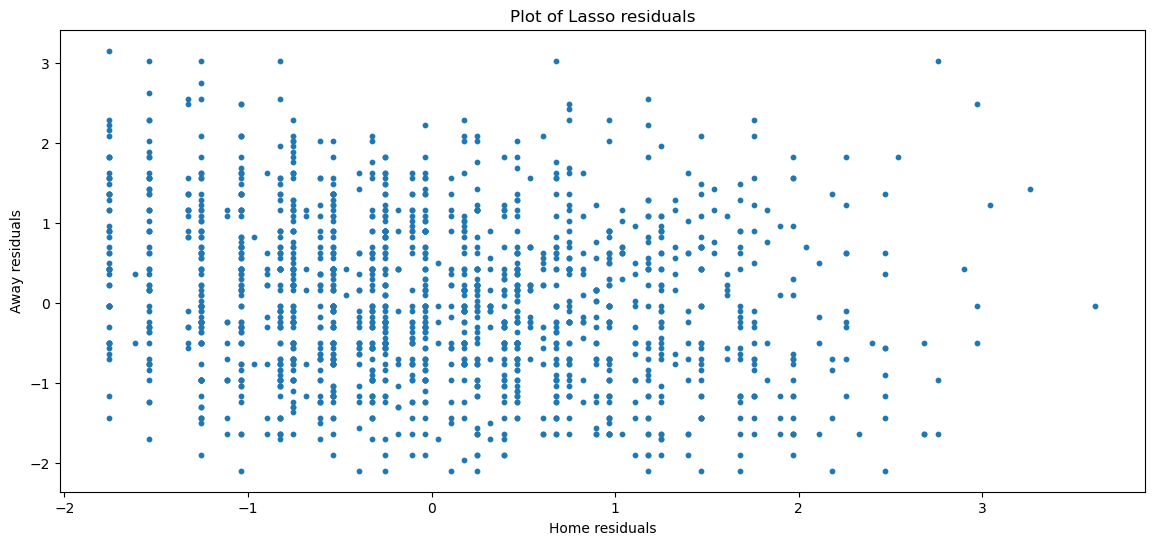

In [237]:
plt.figure(figsize=(14,6))

plt.scatter(x = lasso_residuals[:,0], y = lasso_residuals[:,1], s=10)
plt.title('Plot of Lasso residuals')
plt.xlabel('Home residuals')
plt.ylabel('Away residuals')
plt.show()

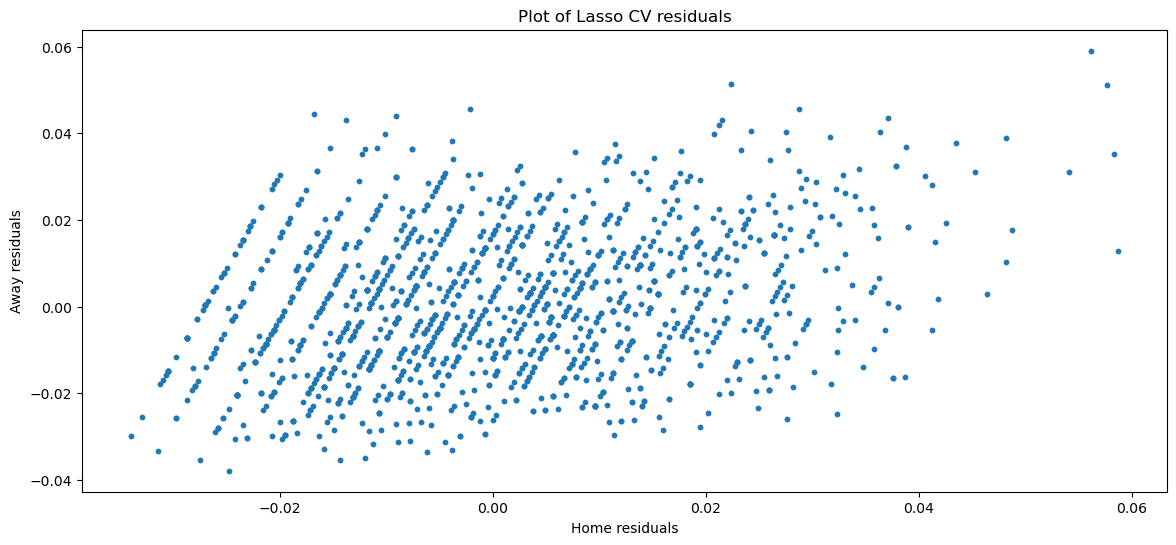

In [238]:
plt.figure(figsize=(14,6))

plt.scatter(x = lasso_cv_residuals[:,0], y = lasso_cv_residuals[:,1], s=10)
plt.title('Plot of Lasso CV residuals')
plt.xlabel('Home residuals')
plt.ylabel('Away residuals')
plt.show()

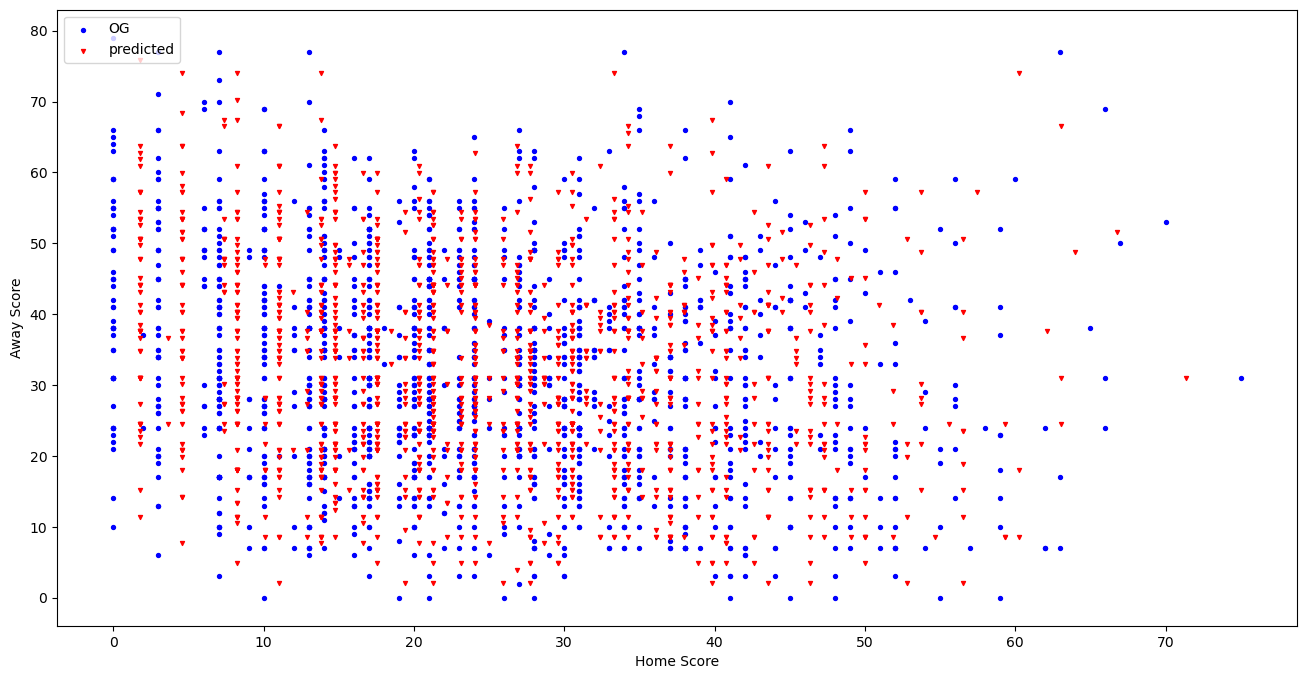

In [248]:
lasso_predictions = lasso.predict(X_test_scaled)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y_test[:,0], y_test[:,1], s=8, c='b', marker="o", label='OG')
ax1.scatter(lasso_predictions[:,0], lasso_predictions[:,1], s=8, c='r', marker="v", label='predicted')

plt.legend(loc='upper left')
plt.xlabel('Home Score')
plt.ylabel('Away Score')
plt.show()

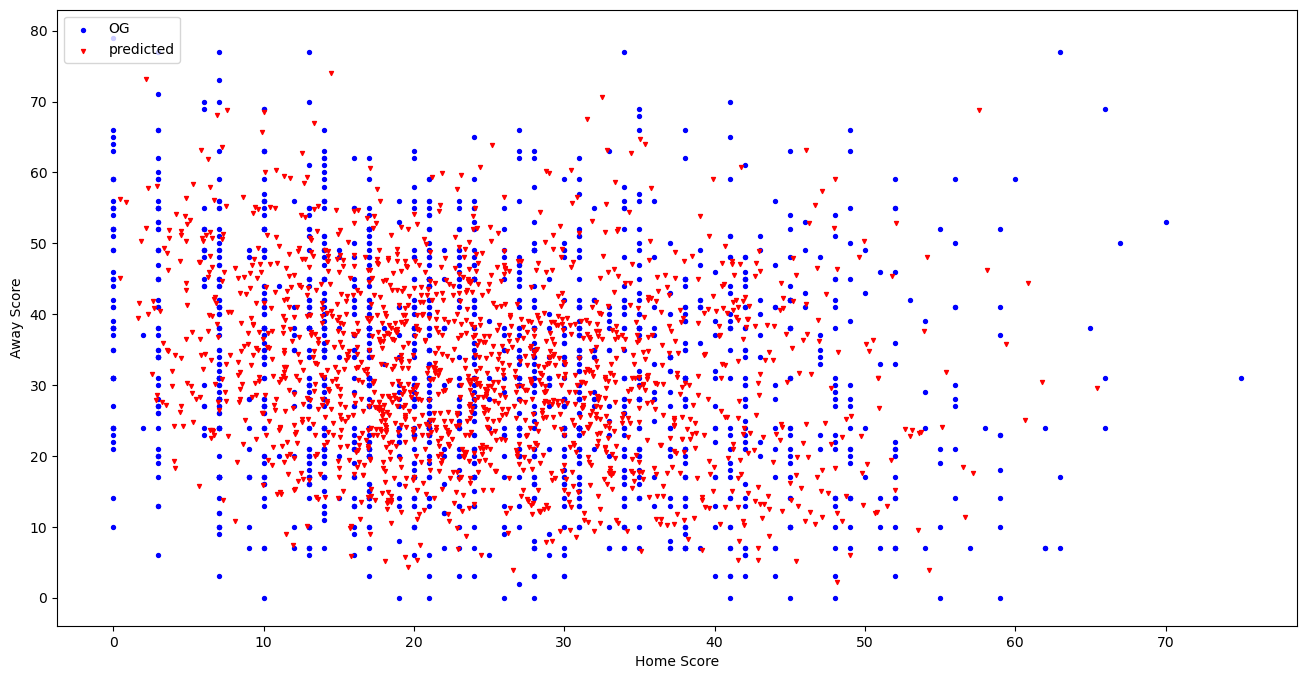

In [244]:

ela_net_cv_predictions = ela_net_cv.predict(X_test_scaled)
ela_net_predictions = ela_net.predict(X_test_scaled)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y_test[:,0], y_test[:,1], s=8, c='b', marker="o", label='OG')
ax1.scatter(ela_net_predictions[:,0], ela_net_predictions[:,1], s=8, c='r', marker="v", label='predicted')

plt.legend(loc='upper left')
plt.xlabel('Home Score')
plt.ylabel('Away Score')
plt.show()

### Map of predicted values vs. Residuals

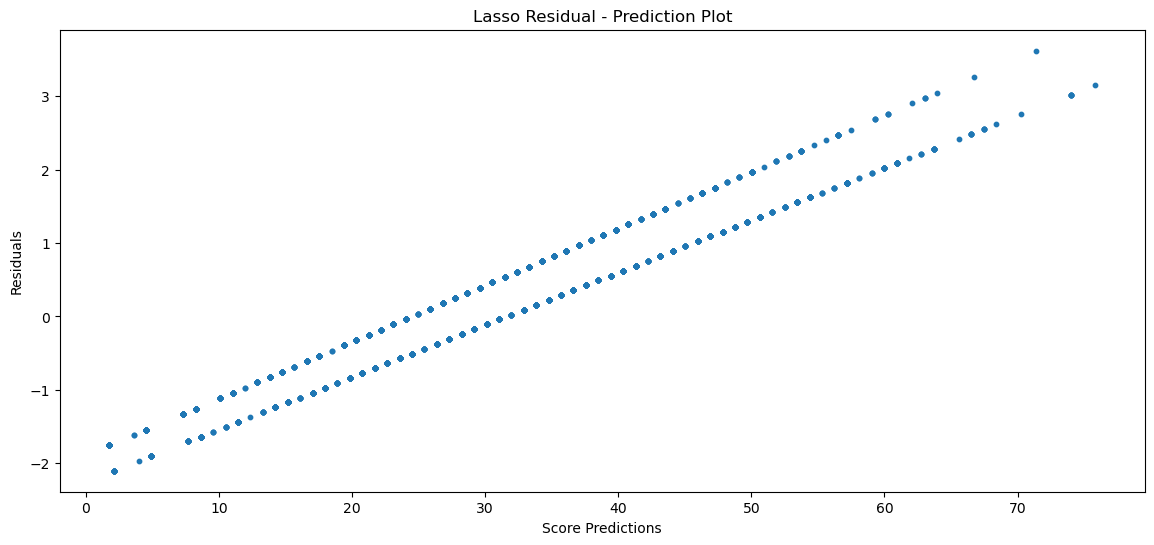

In [249]:
plt.figure(figsize=(14,6))

plt.scatter(x =[lasso_predictions[:,0], lasso_predictions[:,1]] ,  y = [lasso_residuals[:,0], lasso_residuals[:,1]], s=10)
plt.title('Lasso Residual - Prediction Plot')
plt.xlabel('Score Predictions')
plt.ylabel('Residuals')
plt.show()

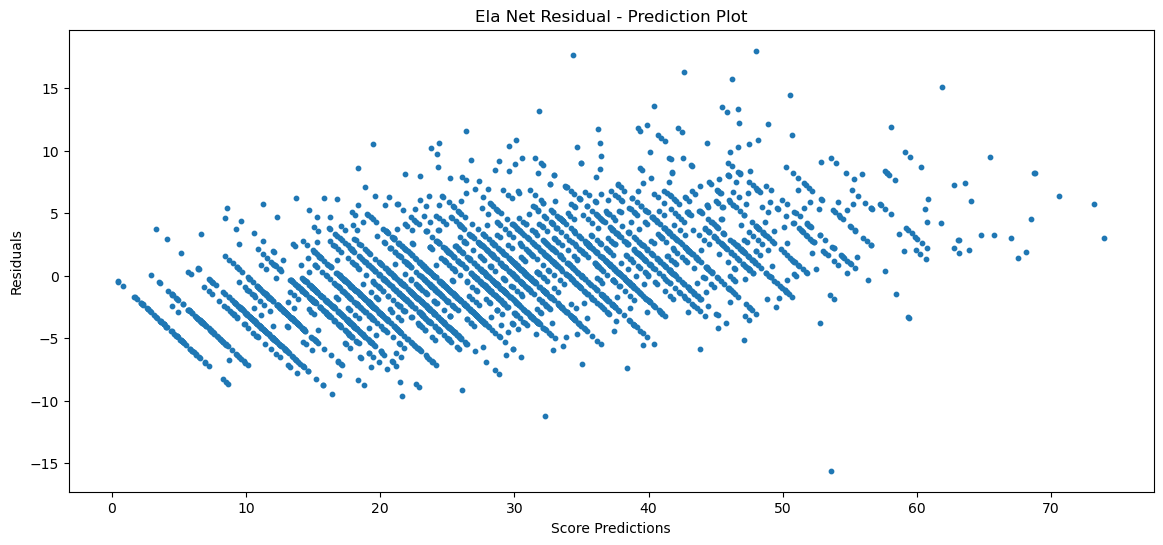

In [250]:
plt.figure(figsize=(14,6))

plt.scatter(x =[ela_net_predictions[:,0], ela_net_predictions[:,1]] ,  y = [ela_net_residuals[:,0], ela_net_residuals[:,1]], s=10)
plt.title('Ela Net Residual - Prediction Plot')
plt.xlabel('Score Predictions')
plt.ylabel('Residuals')
plt.show()

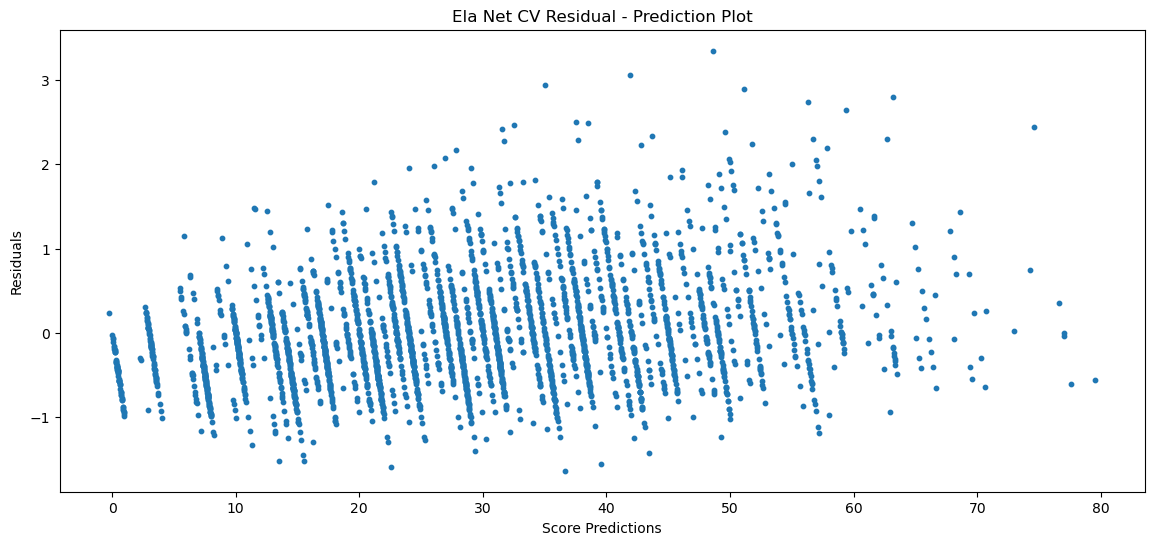

In [252]:
plt.figure(figsize=(14,6))

plt.scatter(x =[ela_net_cv_predictions[:,0], ela_net_cv_predictions[:,1]] ,  y = [ela_net_cv_residuals[:,0], ela_net_cv_residuals[:,1]], s=10)
plt.title('Ela Net CV Residual - Prediction Plot')
plt.xlabel('Score Predictions')
plt.ylabel('Residuals')
plt.show()

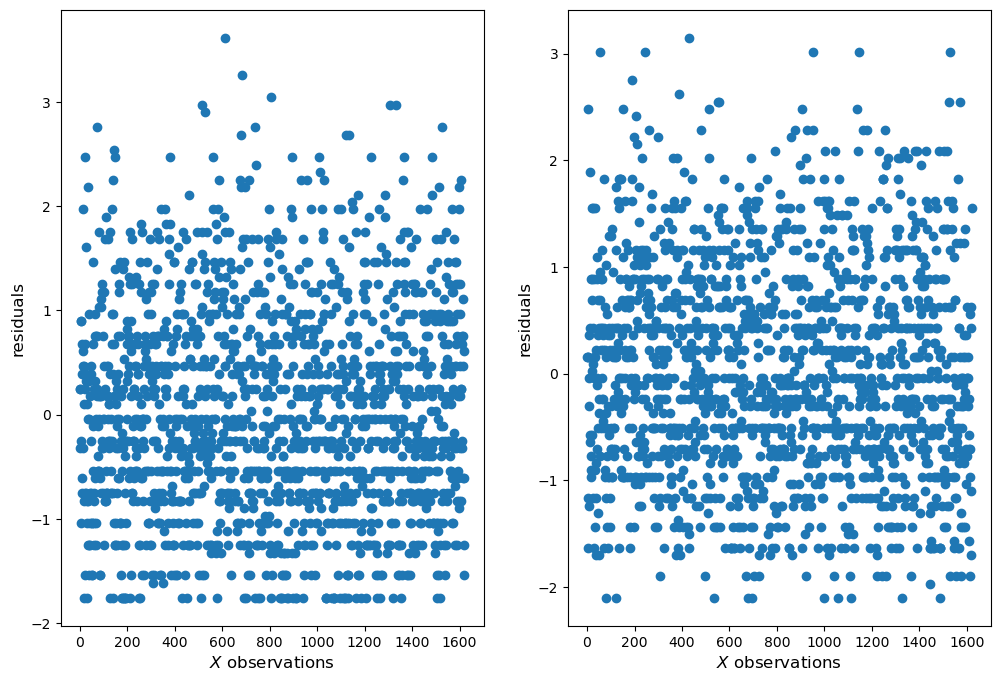

In [306]:
X_test_observation = np.linspace(1,1620,num =1620)

fig,ax = plt.subplots(1,2,figsize=(12,8))


ax[0].scatter(X_test_observation, lasso_residuals[:,0])

ax[0].set_xlabel("$X$ observations", fontsize=12)
ax[0].set_ylabel("residuals", fontsize=12)

ax[1].scatter(X_test_observation, lasso_residuals[:,1])

ax[1].set_xlabel("$X$ observations", fontsize=12)
ax[1].set_ylabel("residuals", fontsize=12)

plt.show()